In [ ]:
#analize models. 

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
import donkeycar as dk
import requests
import pandas as pd
import tarfile
import numpy as np

import os

from PIL import Image

import keras

In [42]:
def get_record_from_df(df, data_path, record_transform=None, shuffle=False):
    
    index = list(df.index)
    if shuffle:
        random.shuffle(index)
    while True:
        for i in index:
            row = dict(df.iloc[i])
            img = Image.open(os.path.join(data_path, row['cam/image_array']))
            row['cam/image_array'] = np.array(img)
            if record_transform:
                row = record_transform(row)
            yield row

    
def get_batch_from_df(keys, df, record_transform=None, batch_size=128,
                      record_tranform=None, data_path=None, shuffle=False):
    
    record_gen = get_record_from_df(df, data_path, record_transform, shuffle=shuffle)
    
    if keys==None:
        keys = list(df.columns)
    while True:
        record_list = []
        for _ in range(batch_size):
            record_list.append(next(record_gen))

        batch_arrays = {}
        for i, k in enumerate(keys):
            arr = np.array([r[k] for r in record_list])
            #if len(arr.shape) == 1:
            #    arr = arr.reshape(arr.shape + (1,))
            batch_arrays[k] = arr

        yield batch_arrays
        
def train_gen(X_keys, Y_keys, df, batch_size=128, data_path=None, 
              record_transform=None):
    
    batch_gen = get_batch_from_df(X_keys+Y_keys, df, batch_size=128, record_transform=None, 
                                  data_path=data_path)
    while True:
        batch = next(batch_gen)
        X = [batch[k] for k in X_keys]
        Y = [batch[k] for k in Y_keys]
        yield X,Y

In [128]:
# Analyze model

In [351]:
tub_path = '/home/wroscoe/d2/data/alan/aw_medium/'
T = dk.parts.Tub(path=tub_path)

df = pd.DataFrame([T.get_json_record(i) for i in T.get_index(shuffled=False)])
print(df.shape)
df = df.dropna()
df.head()

Tub does exist
(4078, 9)


,cam/image_array,measured_throttle,odometer/meters,odometer/meters_per_second,pid_throttle,target_throttle,user/angle,user/mode,user/throttle
0,0_cam-image_array_.jpg,0.169978,75.954661,1.189844,0.240958,0.25,0.000000,user,0.25
1,1_cam-image_array_.jpg,0.180791,76.067917,1.265537,0.347517,0.25,0.000000,user,0.25
2,2_cam-image_array_.jpg,0.204326,76.157297,1.430280,0.410079,0.25,-0.197955,user,0.25
3,3_cam-image_array_.jpg,0.193776,76.222802,1.356429,0.254457,0.25,-0.206207,user,0.25
4,4_cam-image_array_.jpg,0.185968,76.311569,1.301773,0.275952,0.25,0.000000,user,0.25


In [293]:
img_gen = get_batch_from_df(['cam/image_array'], 
                            df, 
                            batch_size=len(df), 
                            data_path=tub_path)
data = next(img_gen)

In [320]:
m = keras.models.load_model('/home/wroscoe/d2/models/aw_ac_1')

In [321]:
predictions = m.predict(data['cam/image_array'])

In [322]:
psteering = predictions[0]
if len(psteering.shape) > 1:
    print('converting to linear output')
    psteering = dk.utils.unbin_Y(psteering)

converting to linear output


In [323]:
df.head()

,cam/image_array,measured_throttle,odometer/meters,odometer/meters_per_second,pid_throttle,target_throttle,user/angle,user/mode,user/throttle,pilot/angle
0,0_cam-image_array_.jpg,0.169978,75.954661,1.189844,0.240958,0.25,0.000000,user,0.25,0.000000
1,1_cam-image_array_.jpg,0.180791,76.067917,1.265537,0.347517,0.25,0.000000,user,0.25,0.000000
2,2_cam-image_array_.jpg,0.204326,76.157297,1.430280,0.410079,0.25,-0.197955,user,0.25,0.000000
3,3_cam-image_array_.jpg,0.193776,76.222802,1.356429,0.254457,0.25,-0.206207,user,0.25,-0.142857
4,4_cam-image_array_.jpg,0.185968,76.311569,1.301773,0.275952,0.25,0.000000,user,0.25,-0.142857


In [324]:
df['pilot/angle'] = psteering

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ef0abf7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3ef02dada0>]], dtype=object)

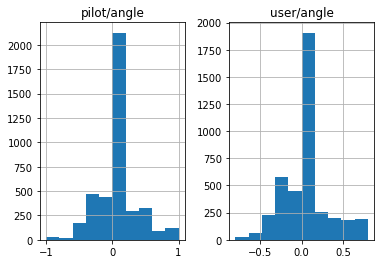

In [325]:
df[['user/angle', 'pilot/angle']].hist()

In [326]:
print(df[['user/angle', 'pilot/angle']].std())

user/angle     0.279672
pilot/angle    0.293042
dtype: float64


In [327]:
print(df[['user/angle', 'pilot/angle']].mean())

user/angle     0.017392
pilot/angle    0.027464
dtype: float64


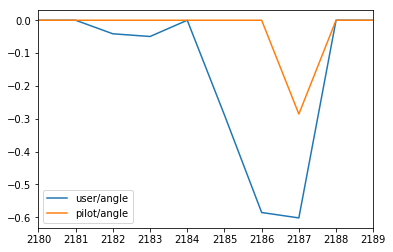

In [333]:
df[['user/angle', 'pilot/angle']][2180:2190].plot()

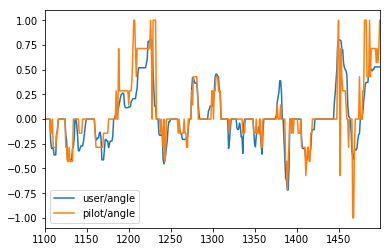

In [319]:
df[['user/angle', 'pilot/angle']][1100:1500].plot()

### Find where model is worst 

In [334]:
df['diff'] = df['user/angle'] - df['pilot/angle']

In [335]:
sdf = df.sort_values('diff', ascending=True)
sdf[:10]

,cam/image_array,measured_throttle,odometer/meters,odometer/meters_per_second,pid_throttle,target_throttle,user/angle,user/mode,user/throttle,pilot/angle,diff
296,296_cam-image_array_.jpg,0.164750,101.117283,1.153250,0.350153,0.25,0.000000,user,0.25,1.000000,-1.000000
2572,2572_cam-image_array_.jpg,0.180253,292.359636,1.261770,0.319548,0.25,0.049464,user,0.25,1.000000,-0.950536
1231,1231_cam-image_array_.jpg,0.169888,179.903333,1.189216,0.342994,0.25,0.131962,user,0.25,1.000000,-0.868038
375,375_cam-image_array_.jpg,0.195972,107.825071,1.371801,0.325440,0.25,0.189679,user,0.25,1.000000,-0.810321
1511,1511_cam-image_array_.jpg,0.167415,203.319677,1.171906,0.279097,0.25,0.000000,user,0.25,0.714286,-0.714286
1032,1032_cam-image_array_.jpg,0.178181,163.641676,1.247267,0.335031,0.25,0.000000,user,0.25,0.714286,-0.714286
1510,1510_cam-image_array_.jpg,0.180345,203.221726,1.262417,0.320457,0.25,0.000000,user,0.25,0.714286,-0.714286
297,297_cam-image_array_.jpg,0.178033,101.193807,1.246234,0.379055,0.25,0.000000,user,0.25,0.714286,-0.714286
1208,1208_cam-image_array_.jpg,0.170199,178.060329,1.191390,0.309203,0.25,0.206183,user,0.25,0.857143,-0.650960
1924,1924_cam-image_array_.jpg,0.185285,237.873630,1.296994,0.378581,0.25,0.354649,user,0.25,1.000000,-0.645351


In [349]:
sdf = sdf.reset_index(drop=True)
row = sdf.iloc[6]
print(row)
data_path = T.path
img = Image.open(os.path.join(data_path, row['cam/image_array']))
arr = np.array(img)

cam/image_array               1510_cam-image_array_.jpg
measured_throttle                              0.180345
odometer/meters                                 203.222
odometer/meters_per_second                      1.26242
pid_throttle                                   0.320457
target_throttle                                    0.25
user/angle                                            0
user/mode                                          user
user/throttle                                      0.25
pilot/angle                                    0.714286
diff                                          -0.714286
Name: 6, dtype: object


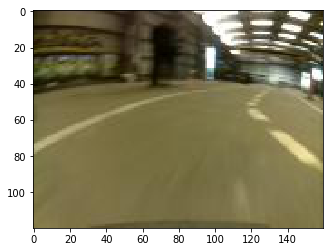

In [350]:
plt.imshow(arr)